In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import os
import itertools
from collections import OrderedDict
import dask
from dask import compute, delayed
import statsmodels.tsa.stattools as ts
import math
import warnings

from scipy.stats import kurtosis
from scipy.stats import skew
 
warnings.filterwarnings('ignore')

from helper import *
from stats import *
from product_info import *
from imp import reload

import helper
import stats

reload(helper)
reload(stats)

CORE_NUM = multiprocessing.cpu_count()
print("Number of processors: ", CORE_NUM)

product_list  = ['bu', 'ru', 'v', 'pp', 'l', 'jd']

HEAD_PATH = '/Users/sean/Desktop/Plan B/Quant/week1'
DATA_PATH = HEAD_PATH + '/energy pkl tick/'

all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
all_dates.sort()

n_days = len(all_dates)

Number of processors:  12


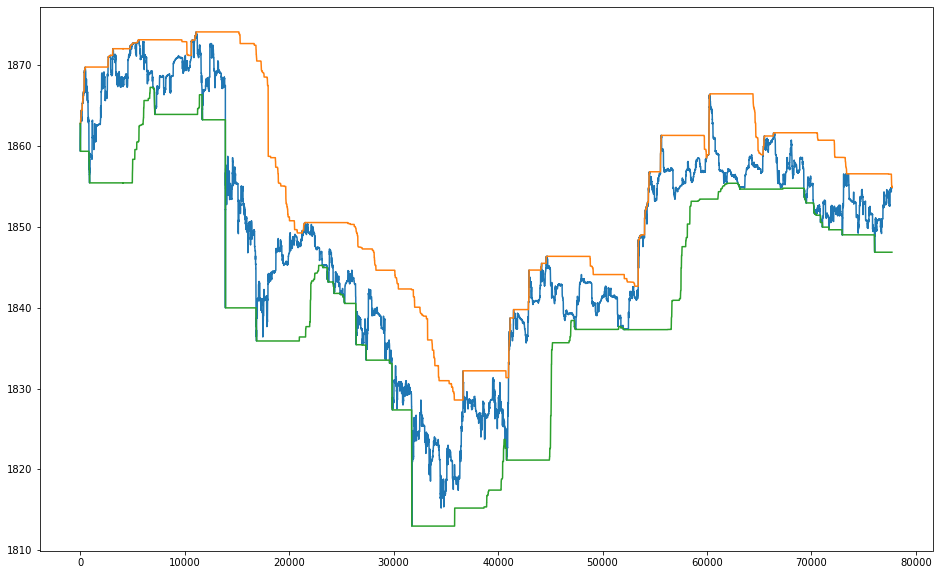

In [2]:
data = load(DATA_PATH + product_list[0]+"/"+all_dates[0])
period_list = [1024, 2048, 4096]

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

In [3]:
period = period_list[2]

class factor_nr_period(factor_template):
    factor_name = 'nr.period'
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data['ret'].abs(), period, adjust=True)).values

def build_simple_signal(file_name, signal_list, product, HEAD_PATH):
    keys = list(signal_list.params.keys())

    data = load(file_name)
    for cartesian in itertools.product(*signal_list.params.values()):
        signal_name = signal_list.factor_name
        for i in range(len(cartesian)):
            signal_name = signal_name.replace(keys[i], str(cartesian[i]))

        path = (
            HEAD_PATH
            + "/tmp pkl/"
            + product
            + "/"
            + signal_name
            + "/"
            + file_name[-12:]
        )
        S = signal_list.formula(data, *cartesian)
        save(S, path)
    
def create_signal_path(signal_list, product, HEAD_PATH):
    keys = list(signal_list.params.keys())
    for cartesian in itertools.product(*signal_list.params.values()):
        signal_name = signal_list.factor_name
        for i in range(len(cartesian)):
            signal_name = signal_name.replace(keys[i], str(cartesian[i]))
        
        os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name, exist_ok=True)
        print(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name)    
    

x_0 = factor_nr_period()
SAVE_PATH = HEAD_PATH + '/factor'
for product in product_list:
    create_signal_path(x_0, product, SAVE_PATH)

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/nr.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/nr.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/nr.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/nr.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/nr.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/nr.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/nr.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/nr.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/nr.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/nr.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/nr.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/nr.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/nr.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/nr.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/nr.4096
/Users/sean/Desktop/Plan B/Quan

In [4]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + product + '/' + x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list = x_0, product = product, HEAD_PATH = SAVE_PATH);

CPU times: user 29.2 s, sys: 1.99 s, total: 31.1 s
Wall time: 4min 12s


In [5]:
def add_min_max(file, period_list):
    data = load(file)
    for period in period_list:
        data['min.'+ str(period)] = data['wpr'].rolling(period).min()
        data.loc[:period, ('min.' + str(period))] = np.minimum.accumulate(data['wpr'].iloc[:period])
        data['max.' + str(period)] = data['wpr'].rolling(period).max()
        data.loc[:period, ('max.' + str(period))] = np.maximum.accumulate(data['wpr'].iloc[:period])
    save(data, file)

In [6]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + product + '/' + x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, add_min_max, period_list = period_list);

CPU times: user 13 s, sys: 1.82 s, total: 14.8 s
Wall time: 4min 2s


In [7]:
def zero_divide(x, y):
    '''
    returns 0 if the numerator or denominator is 0
    '''
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        res = np.divide(x, y)
    if hasattr(y, "__len__"):
        res[y==0] = 0
    elif y == 0:
        if hasattr(x, "__len__"):
            res = np.zeros(len(x))
        else:
            res = 0
    return res

def vanish_thre(x, thre):
    x[np.abs(x)>thre] = 0
    return x

def ewma(x, halflife, init=0, adjust=False):
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

class factor_dbook_period(factor_template):
    factor_name = 'dbook.period'
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data['bid.qty'] - data['bid.qty'].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data['ask.qty'] - data['ask.qty'].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty) - np.sign(diff_ask_qty), period, adjust=True).values
    
x_1 = factor_dbook_period()
print(x_1)
for product in product_list:
    create_signal_path(x_1, product, SAVE_PATH)

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data['bid.qty'] - data['bid.qty'].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data['ask.qty'] - data['ask.qty'].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty) - np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[1024 2048 4096]

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/dbook.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/dbook.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/dbook.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/dbook.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/dbook.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/dbook.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/dbook.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/dbook.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/dbook.4096
/

In [8]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + product + '/' + x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x_1, product=product, HEAD_PATH=SAVE_PATH);

CPU times: user 27.7 s, sys: 1.8 s, total: 29.5 s
Wall time: 3min 30s


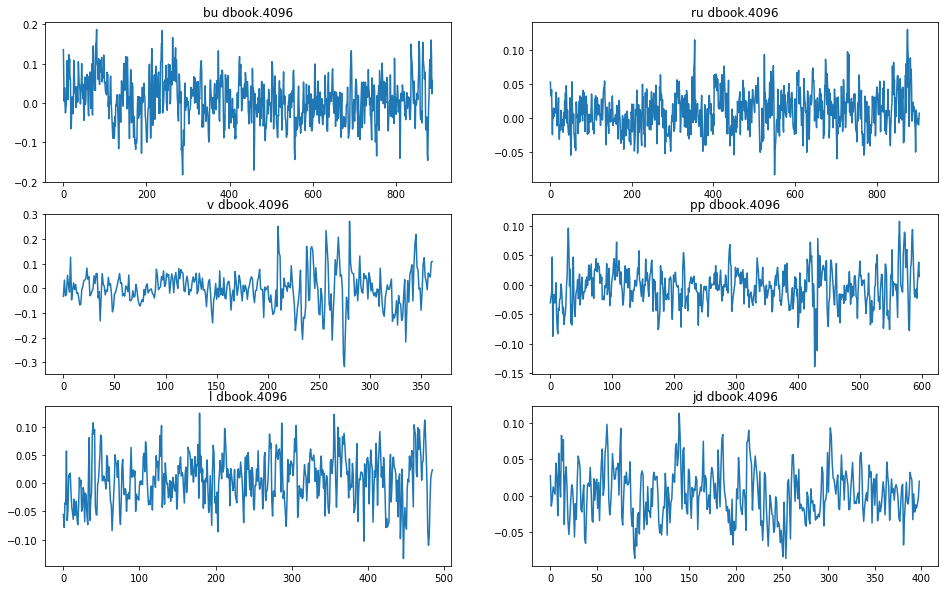

In [107]:
def moving_average(a, n=3):
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret

def get_all_signal(file_list, product, signal_name, period, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH):
    n_files = len(file_list)
    to_choose = (np.arange(n_files)+1) % 10 == 0
    all_signal = np.array([])
    for file in file_list[to_choose]:
        S = load(SIGNAL_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
        data = load(HEAD_PATH +"/energy pkl tick/" + product + '/' + file)
        signal = S[data['good']]
        chosen = (np.arange(len(signal))+1) % period == 0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis = 0)
    return all_signal

i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, 'dbook.' + str(period), period, HEAD_PATH, SAVE_PATH)
    i += 1
    plt.figure(1, figsize=(16,10))
    plt.subplot(3,2,i)
    plt.title(product + " dbook.4096")
    plt.plot(all_signal)

In [18]:
open_list = np.arange(0.04, 0.1, 0.003)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([
    ("open", thre_list[:, 0]),
    ("close", thre_list[:, 1])
]))

- get the result of training sample

In [11]:
period = 4096
signal_name = "dbook." + str(period)

train_sample = np.array(all_dates) < "201807"
test_sample = np.array(all_dates) > "201807"
print(sum(train_sample), sum(test_sample))

507 581


In [102]:
def get_signal_pnl(
    file,
    product,
    signal_name,
    thre_mat,
    reverse=1,
    tranct=1.1e-4,
    max_spread=0.61,
    tranct_ratio=True,
    HEAD_PATH=HEAD_PATH,
    SIGNAL_PATH=SAVE_PATH,
    atr_filter=0,
    rebate=0,
):
    ## load data
    data = load(HEAD_PATH + "/energy pkl tick/" + product + "/" + file)
    S = load(SIGNAL_PATH + "/tmp pkl/" + product + "/" + signal_name + "/" + file)
    pred = S * reverse
    data = data.reset_index(drop=True)
    pred = pred[data["good"]]
    atr = load(
        SIGNAL_PATH + "/tmp pkl/" + product + "/" + "atr.4096" + "/" + file
    ).reset_index(drop=True)
    atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)

    
    result = pd.DataFrame(
        data=OrderedDict(
            [
                ("open", thre_mat["open"].values),
                ("close", thre_mat["close"].values),
                ("num", 0),
                ("avg.pnl", 0),
                ("pnl", 0),
                ("avg.ret", 0),
                ("ret", 0),
            ]
        ),
        index=thre_mat.index,
    )
    count = 0
    cur_spread = data["ask"] - data["bid"]
    for thre in thre_mat.iterrows():
        count = count + 1
        buy = pred > thre[1]["open"]
        sell = pred < -thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr < atr_filter] = 0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[
            (signal == 1)
            & (data["next.ask"] > 0)
            & (data["next.bid"] > 0)
            & (cur_spread < max_spread)
        ] = 1
        position_pos[
            (pred < -scratch) & (data["next.bid"] > 0) & (cur_spread < max_spread)
        ] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos == 1] = 1
        notional_position_pos[(position_pos == 1) & (pre_pos == 1)] = np.nan
        notional_position_pos[(notional_position_pos == 1)] = (
            1 / data["next.ask"][(notional_position_pos == 1)]
        )
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[
            (signal == -1)
            & (data["next.ask"] > 0)
            & (data["next.bid"] > 0)
            & (cur_spread < max_spread)
        ] = -1
        position_neg[
            (pred > scratch) & (data["next.ask"] > 0) & (cur_spread < max_spread)
        ] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg == -1] = -1
        notional_position_neg[(position_neg == -1) & (pre_neg == -1)] = np.nan
        notional_position_neg[(notional_position_neg == -1)] = (
            -1 / data["next.bid"][(notional_position_neg == -1)]
        )
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos + notional_position_neg
        # position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position - notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos > 0
        change_sell = change_pos < 0
        if tranct_ratio:
            change_base[change_buy] = data["next.ask"][change_buy] * (1 + tranct)
            change_base[change_sell] = data["next.bid"][change_sell] * (1 - tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy] + tranct
            change_base[change_sell] = data["next.bid"][change_sell] - tranct
        final_pnl = -sum(change_base * change_pos)
        ret = -sum(change_base * notional_change_pos)
        num = sum((position != 0) & (change_pos != 0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (
                0,
                0,
                0,
                0,
                0,
            )
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret, num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (
                num,
                avg_pnl,
                final_pnl,
                avg_ret,
                ret,
            )
    return result


In [19]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
## reverse = -1
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

# backtest result
save(all_trade_stat, SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")

CPU times: user 32.2 s, sys: 2.39 s, total: 34.6 s
Wall time: 21min 27s


In [22]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
#reverse = 1
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

save(all_trade_stat, SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pos.pkl")

CPU times: user 32.6 s, sys: 2.38 s, total: 34.9 s
Wall time: 22min 13s


##### Get the statistics result

In [23]:
all_trade_stat = load(SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pos.pkl")

date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

i = 0
for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]['tranct']
    tranct_ratio = product_info[product]['tranct.ratio']
    
    good_strat = trade_stat['final.result']['avg.pnl'] > 2*spread
    if sum(good_strat) > 1:
        good_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        plt.figure(1, figsize=(16,10))
        i = i + 1
        plt.subplot(3,2,i)
        plt.title(" ")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum());

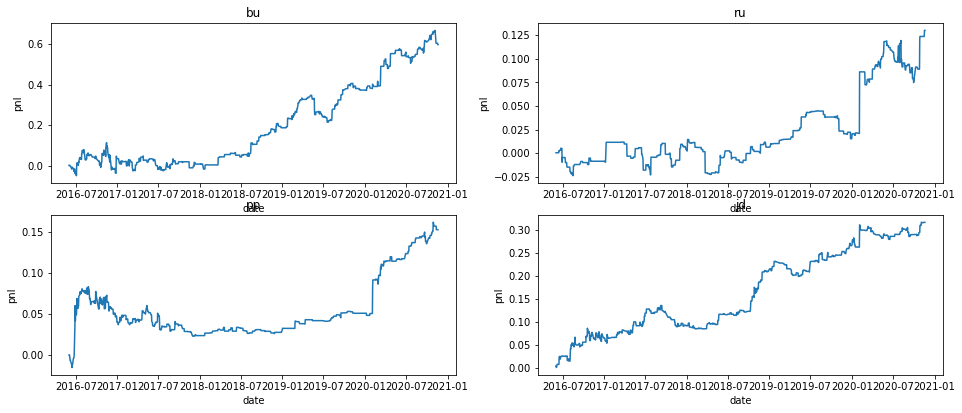

In [24]:
all_trade_stat = load(SAVE_PATH+"/"+"energy_trade_stat_"+signal_name+".pkl")

date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

i = 0
for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]['tranct']
    tranct_ratio = product_info[product]['tranct.ratio']
    
    good_strat = trade_stat['final.result']['avg.pnl'] > 2*spread
    if sum(good_strat) > 1:
        good_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        plt.figure(1, figsize=(16,10))
        i = i + 1
        plt.subplot(3,2,i)
        plt.title(" ")
        plt.xlabel("date")
        plt.ylabel("pnl")
        plt.title(product)
        plt.plot(format_dates, good_pnl.cumsum());

CPU times: user 15.9 s, sys: 1.4 s, total: 17.3 s
Wall time: 11min 56s


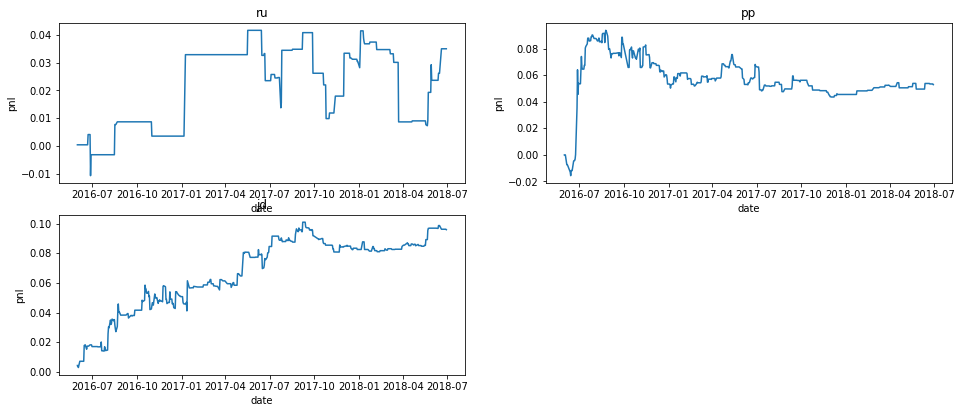

In [27]:
%%time
train_trade_stat = {}
for product in product_list:
    spread = product_info[product]['spread']
    tranct = product_info[product]['tranct']
    tranct_ratio = product_info[product]['tranct.ratio']
    
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio,
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat

save(train_trade_stat, SAVE_PATH+"/" + signal_name+"_energy_train_trade_stat.pkl")

i = 0
train_trade_stat = load(SAVE_PATH+"/" + signal_name +"_energy_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        plt.figure(1, figsize=(16, 10));
        i = i+1
        plt.subplot(3,2,i)
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[train_sample], good_pnl.cumsum());

In [33]:
%%time
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat
    
save(test_trade_stat, SAVE_PATH+"/" + signal_name + "_energy_test_trade_stat.pkl")

CPU times: user 18.2 s, sys: 1.54 s, total: 19.7 s
Wall time: 11min 55s


ru
Training Sample Sharpe:  0.4073560478429341
Test Sample Sharpe:  0.758801523528004
pp
Training Sample Sharpe:  0.4837779045178518
Test Sample Sharpe:  1.662380128606333
jd
Training Sample Sharpe:  1.2596643504513176
Test Sample Sharpe:  1.0524203322598276


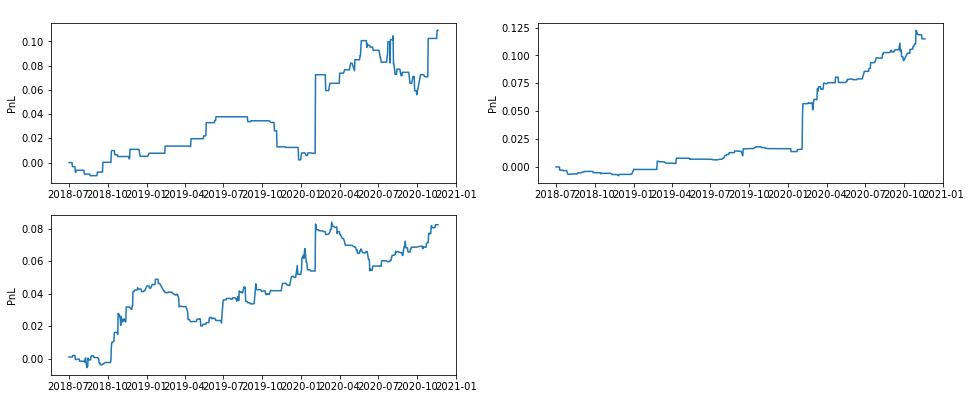

In [38]:
train_trade_stat = load(SAVE_PATH+"/" + signal_name+"_energy_train_trade_stat.pkl")
test_trade_stat = load(SAVE_PATH+"/" + signal_name + "_energy_test_trade_stat.pkl")

i = 0

train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])

for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat['final.result']['avg.pnl'] > 2*spread) & (trade_stat['final.result']['num'] > 20)
    if sum(good_strat)>0:
        train_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        trade_stat = test_trade_stat[product]
        test_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product)
        print("Training Sample Sharpe: ", sharpe(train_pnl))
        print("Test Sample Sharpe: ", sharpe(test_pnl))

        test_all_pnl[:, i] = test_pnl
        train_all_pnl[:, i] = train_pnl
        plt.figure(1, figsize=(16,10))
        i += 1
        plt.subplot(3,2,i)
        plt.title(" ")
        plt.ylabel("PnL")
        plt.plot(format_dates[test_sample], test_pnl.cumsum());

- Portfolio PnL and Statistics

Train Sharpe:  1.2196908794967356
Test Sharpe:  1.2984106572252367


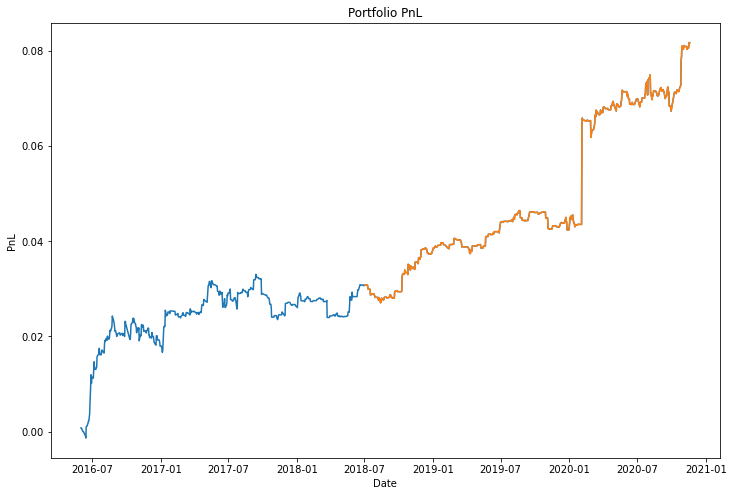

In [39]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)

print("Train Sharpe: ", sharpe(train_portfolio))
print("Test Sharpe: ", sharpe(test_portfolio))
plt.figure(1, figsize=(12,8))
plt.title("Portfolio PnL")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.plot(format_dates, all_portfolio.cumsum())
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample]);

In [40]:
print(sharpe(train_portfolio), sharpe(test_portfolio))

1.2196908794967356 1.2984106572252367


In [41]:
atr_filter_list = {}
for product in product_list:
    atr_filter_list[product] = 0.01

reverse_list = {}
for product in product_list:
    reverse_list[product] = -1
    
thre_mat_list = {}
for product in product_list:
    thre_mat_list[product] = thre_mat

In [116]:
def get_list_signal_stat(signal_name, thre_mat_list, product_list, all_dates, atr_filter_list,
                         split_str="2018", min_pnl=2, min_num=20, reverse=1):
    """
    signal_name: string
    thre_mat_list: dictionary contains threshold interval
    product_list: dictionary contains product names
    all_dates: index of prices
    atr_filter_list: dictionary contains absolute true range
    split_str: split point for train/test
    min_pnl: int
    max_pnl: int
    
    """
    
    CORE_NUM = multiprocessing.cpu_count()
    
    train_sample = np.array(all_dates) < split_str
    test_sample = np.array(all_dates) > split_str
    
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    
    train_trade_stat = {}
    print("Training Sample")
    
    for product in product_list:
        print("Working on " + product)
        spread = product_info[product]['spread']
        tranct = product_info[product]['tranct']
        tranct_ratio = product_info[product]['tranct.ratio']
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                      reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio,
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH, atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
        train_trade_stat[product] = trade_stat
    print("Training " + product + "Done!")
    print("==================================================================")
    print("Testing Sample")    
    test_trade_stat = {}
    for product in product_list:
        print("Working on " + product)
        spread = product_info[product]['spread']
        tranct = product_info[product]['tranct']
        tranct_ratio = product_info[product]['tranct.ratio']
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                      reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio,
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH, atr_filter=atr_filter)
            test_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
        test_trade_stat[product] = trade_stat
    print("Testing " + product + "Done!")  
    
    result = {}
    result["Train_Trade_Stat"] = train_trade_stat
    result["Test_Trade_Stat"] = test_trade_stat
    
    if reverse == -1:
        save(result, HEAD_PATH+"/"+signal_name+".result.pkl")
    else:
        save(result, HEAD_PATH+"/"+signal_name+".pos.result.pkl")
        

def get_list_signal_result(signal_name, product_list, all_dates, split_str='2018', reverse=1,
                           min_pnl=2, min_num=20):

    if reverse == -1:
        result = load(HEAD_PATH+"/"+signal_name+".result.pkl")
    else:
        result = load(HEAD_PATH + '/' + signal_name + '.pos.result.pkl')

    train_trade_stat = result['Train_Trade_Stat']
    test_trade_stat = result['Test_Trade_Stat']
    train_sample = np.array(all_dates) < split_str
    test_sample = np.array(all_dates) > split_str
    
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    
    for product in product_list:
        spread = product_info[product]['spread']
        trade_stat = train_trade_stat[product]
        
        good_strat = (trade_stat['final.result']['avg.pnl'] > min_pnl*spread) & (trade_stat['final.result']['num'] > min_num)
        
        if sum(good_strat)>0:
            train_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            train_std = np.std(train_pnl)
            train_pnl = train_pnl/train_std
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
            print("Product: ", product)
            print("Train Sharpe: ", sharpe(train_pnl))
            print("Test Sharpe: ", sharpe(test_pnl))
            test_all_pnl[:, i] = test_pnl
            train_all_pnl[:, i] = train_pnl
            i += 1
        if i > 0:
            train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
            test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
            all_portfolio = np.append(train_portfolio, test_portfolio)
            plt.figure(1, figsize=(16, 10));
            plt.subplot(3,2,i)
            plt.title("");
            plt.xlabel("date");
            plt.ylabel("pnl");
            plt.title("portfolio");
            plt.plot(format_dates, all_portfolio.cumsum());
            plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
            signal_stat = dict([])
            signal_stat["train.stat"] = train_trade_stat
            signal_stat["test.stat"] = test_trade_stat
            print("Train Sharpe: ", sharpe(train_portfolio))
            print("Test Sharpe: ", sharpe(test_portfolio))

In [56]:
%%time
get_list_signal_stat("dbook.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                     split_str="201807", min_pnl=2, min_num=20, reverse=-1)


Training Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Testing Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
CPU times: user 33.2 s, sys: 3.02 s, total: 36.3 s
Wall time: 22min 3s


Product:  ru
Train Sharpe:  0.40735604784293256
Test Sharpe:  0.7588015235280056
Train Sharpe:  0.4073560478429335
Test Sharpe:  0.7588015235280058
Train Sharpe:  0.4073560478429335
Test Sharpe:  0.7588015235280058
Product:  pp
Train Sharpe:  0.4837779045178575
Test Sharpe:  1.6623801286063233
Train Sharpe:  0.6704216016565925
Test Sharpe:  1.1148813033714478
Train Sharpe:  0.6704216016565925
Test Sharpe:  1.1148813033714478
Product:  jd
Train Sharpe:  1.259664350451322
Test Sharpe:  1.0524203322598336
Train Sharpe:  1.2981752368548776
Test Sharpe:  1.2577667631943532


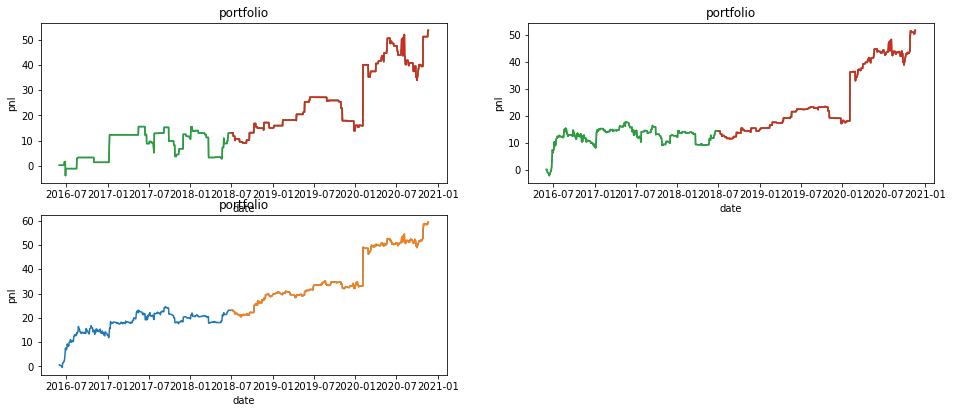

In [73]:
get_list_signal_result("dbook.4096", product_list, all_dates, split_str="201807",
                       reverse=-1,min_pnl=2, min_num=20)

- any price is between minimum and maximum
- so if we use (price-min)/(max-min), the result is between [0,1]
- 0 is min, 1 is max
- then we subtract 0.5 from it
- then result is between -0.5 to 0.5
- and finally use ewma to take the average result over a range

In [80]:
def get_range_pos(wpr, min_period, max_period, period):
    return ewma(zero_divide(wpr-min_period, max_period-min_period), period, adjust=True) - 0.5


class factor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2,range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data['wpr'], data['min.'+str(period)], data['max.'+str(period)], period).values

In [81]:
x_2 = factor_range_pos_period()
for product in product_list:
    create_signal_path(x_2, product, SAVE_PATH)

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/range.pos.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/range.pos.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/range.pos.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/range.pos.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/range.pos.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/range.pos.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/range.pos.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/range.pos.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/range.pos.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/range.pos.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/range.pos.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/range.pos.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/range.pos.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/range.pos.20

In [82]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x_2, product=product, HEAD_PATH=SAVE_PATH);


CPU times: user 30.6 s, sys: 2.02 s, total: 32.6 s
Wall time: 3min 46s


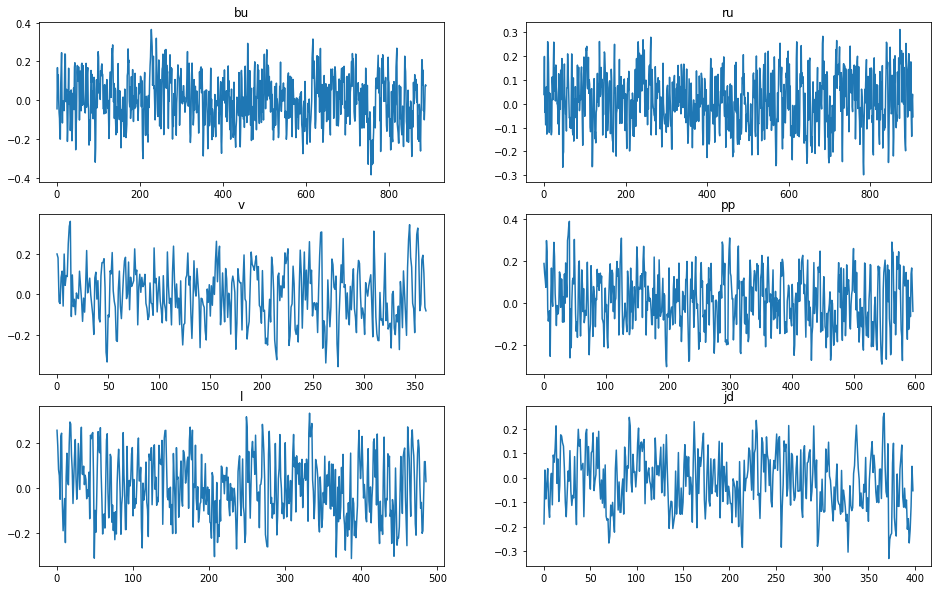

In [84]:
signal_name = 'range.pos.4096'

i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, 'range.pos.'+str(period), period, SIGNAL_PATH=SAVE_PATH)
    plt.figure(1, figsize=(16,10))
    i += 1
    plt.subplot(3,2,i)
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [85]:
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [86]:
%%time
signal_stat = get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="201807", min_pnl=2, min_num=20, reverse=-1)

Training Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Training jdDone!
Testing Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Testing jdDone!
CPU times: user 35.2 s, sys: 3.18 s, total: 38.4 s
Wall time: 31min 49s


In [88]:
%%time
signal_stat = get_list_signal_result("range.pos.4096", product_list, all_dates, split_str="201807", reverse=-1, 
                                   min_pnl=2, min_num=0)

CPU times: user 177 ms, sys: 12.6 ms, total: 190 ms
Wall time: 190 ms


- double moving average
- long is period short is round(period/10)
- we can use this idea to consturct many combinations

In [87]:
class factor_ma_diff_period(factor_template):
    factor_name = 'ma.dif.10.period'
    
    params = OrderedDict([
        ('period', np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data['wpr'], round(period/10), adjust=True) - ewma(data['wpr'], period, adjust=True), data['wpr']).values

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/ma.dif.10.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/ma.dif.10.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/ma.dif.10.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/ma.dif.10.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/ma.dif.10.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/ma.dif.10.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/ma.dif.10.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/ma.dif.10.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/ma.dif.10.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/ma.dif.10.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/ma.dif.10.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/ma.dif.10.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/ma.dif.10.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/ma.dif.10.20

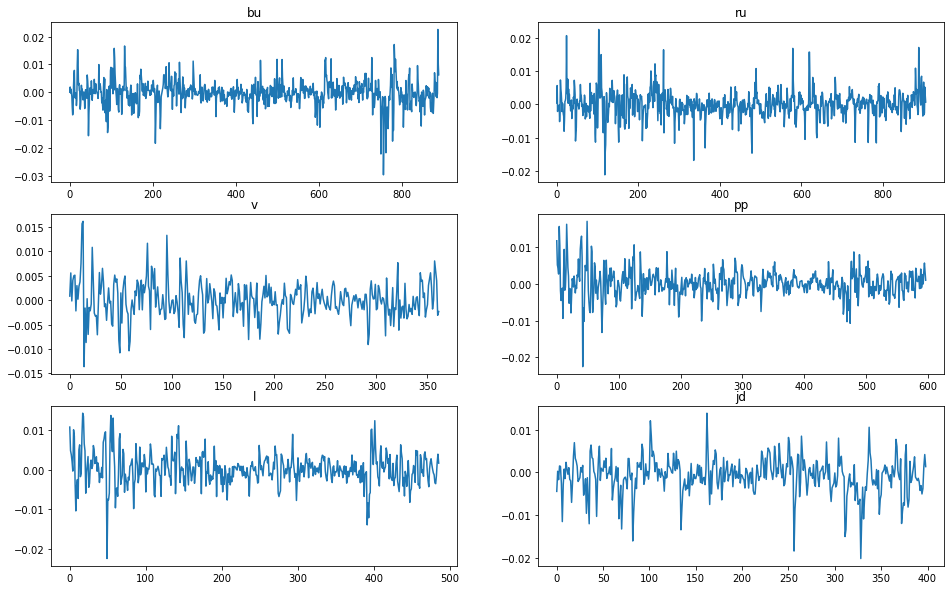

In [94]:
%%time
x_3 = factor_ma_diff_period()

for product in product_list:
    create_signal_path(x_3, product, SAVE_PATH)

for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+'/'+x, os.listdir(DATA_PATH+product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x_3, product=product, HEAD_PATH=SAVE_PATH);
    
period = 4096

i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, 'ma.dif.10.'+str(period), period, SIGNAL_PATH=SAVE_PATH)
    plt.figure(1, figsize=(16,10))
    i += 1
    plt.subplot(3,2,i)
    plt.title(product)
    plt.plot(all_signal)

In [92]:
open_list = np.arange(0.005, 0.015, 0.0005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [95]:
%%time
signal_stat = get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="201807", min_pnl=2, min_num=20, reverse=-1)


signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, all_dates, 
                                     split_str="201807", reverse=-1, min_pnl=2, min_num=20)

Training Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Training jdDone!
Testing Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Testing jdDone!
CPU times: user 34.8 s, sys: 3.14 s, total: 37.9 s
Wall time: 24min 21s


- similar to double ewma
- but divided by price range
- and short period is round(period/20)
- for exampl.e period/2, period/4, period/8...
- now period = 4096 =2^12, 

In [97]:
class factor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data['wpr'], round(period/20), adjust=True) - ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

x_4 = factor_price_osci_period()
for product in product_list:
    create_signal_path(x_4, product, SAVE_PATH)

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/price.osci.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/price.osci.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/price.osci.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/price.osci.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/price.osci.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/price.osci.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/price.osci.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/price.osci.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/price.osci.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/price.osci.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/price.osci.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/price.osci.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/price.osci.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l

In [99]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+'/'+x, os.listdir(DATA_PATH+product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x_4, product=product,HEAD_PATH=SAVE_PATH);

CPU times: user 31.2 s, sys: 2.12 s, total: 33.3 s
Wall time: 4min 49s


In [101]:
SAVE_PATH

'/Users/sean/Desktop/Plan B/Quant/week1/factor'

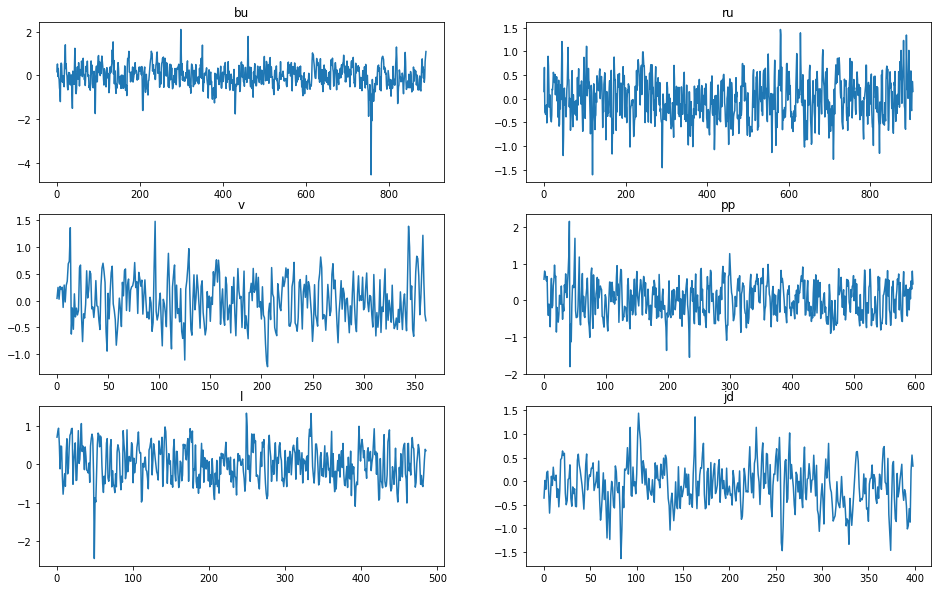

In [108]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, 'price.osci.'+str(period), period, SIGNAL_PATH=SAVE_PATH)
    plt.figure(1, figsize=(16,10))
    i += 1
    plt.subplot(3,2,i)
    plt.title(product)
    plt.plot(all_signal)

In [114]:
open_list = np.arange(0.07, 0.15, 0.004)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [119]:
%%time
signal_stat = get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="201807", min_pnl=2, min_num=20, reverse=-1)

signal_stat = get_list_signal_result("price.osci.4096", product_list, all_dates, split_str="201807", reverse=-1, min_pnl=2, min_num=20)

Training Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Training jdDone!
Testing Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Testing jdDone!
CPU times: user 34.2 s, sys: 3.17 s, total: 37.4 s
Wall time: 53min 19s


##### Skew and Kurtosis

In [120]:
def get_signal_moment(signal, all_dates, product_list, period):
    for product in product_list:
        all_signal = get_all_signal(np.array(all_dates), product, signal+'.'+str(period), period, SIGNAL_PATH=SAVE_PATH)
        all_signal = all_signal[np.isnan(all_signal)==False]
        print("Product: ", product)
        print('Kurtosis: ', kurtosis(all_signal, fisher=False))
        print('Skewness: ', skew(all_signal))

In [126]:
%%time
print("dbook")
print(get_signal_moment('dbook', all_dates, product_list, 4096))
print("------------------------------------------")
print('range.pos')
print(get_signal_moment('range.pos', all_dates, product_list, 4096))
print("------------------------------------------")
print('ma.dif.10')
print(get_signal_moment('ma.dif.10', all_dates, product_list, 4096))
print("------------------------------------------")
print('price.osci')
print(get_signal_moment('price.osci', all_dates, product_list, 4096))
print("------------------------------------------")
print('nr')
print(get_signal_moment('nr', all_dates, product_list, 4096))

dbook
Product:  bu
Kurtosis:  3.155665449532826
Skewness:  0.06668196118895177
Product:  ru
Kurtosis:  3.617191236983143
Skewness:  0.3378848565027072
Product:  v
Kurtosis:  5.506255336815852
Skewness:  -0.07644171600414075
Product:  pp
Kurtosis:  4.169193466800796
Skewness:  -0.05829103055452134
Product:  l
Kurtosis:  2.9083619115847315
Skewness:  -0.058175236019974735
Product:  jd
Kurtosis:  2.967667732962126
Skewness:  0.2018386073502498
None
------------------------------------------
range.pos
Product:  bu
Kurtosis:  2.631095816173791
Skewness:  -0.04088971298276655
Product:  ru
Kurtosis:  2.451382271150854
Skewness:  -0.03453377755475763
Product:  v
Kurtosis:  2.5834153711584187
Skewness:  0.004219596889751937
Product:  pp
Kurtosis:  2.4465747208270634
Skewness:  0.016834102252579326
Product:  l
Kurtosis:  2.2382804720947567
Skewness:  0.042378575282050523
Product:  jd
Kurtosis:  2.4257271108942975
Skewness:  -0.03820941575764657
None
------------------------------------------
ma.

In [127]:
class factor_kdj_k_period(factor_template):
    factor_name = 'kdj.k.period'
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/kdj.k.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/kdj.k.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/kdj.k.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/kdj.k.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/kdj.k.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/kdj.k.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/kdj.k.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/kdj.k.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/kdj.k.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/kdj.k.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/kdj.k.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/kdj.k.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/kdj.k.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/kdj.k.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl

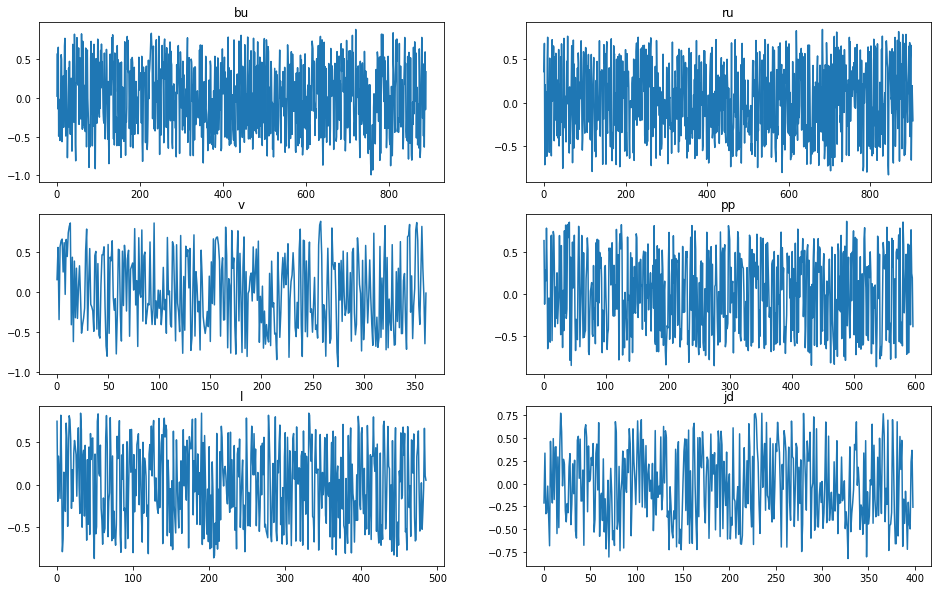

In [129]:
%%time
x_5 = factor_kdj_k_period()
for product in product_list:
    create_signal_path(x_5, product, SAVE_PATH)
    

for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x_5, product=product, HEAD_PATH=SAVE_PATH);
    
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, 'kdj.k.'+str(period), period, SIGNAL_PATH=SAVE_PATH)
    plt.figure(1, figsize=(16,10))
    i += 1
    plt.subplot(3,2,i)
    plt.title(product)
    plt.plot(all_signal)
    print("Product: ", product)
    print("Kurtosis: ", kurtosis(all_signal, fisher=False))
    print("Skewness: ", skew(all_signal))

- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

In [130]:
open_list = np.arange(0.6, 0.8, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

Training Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Training jdDone!
Testing Sample
Working on bu
Working on ru
Working on v
Working on pp
Working on l
Working on jd
Testing jdDone!
Product:  ru
Train Sharpe:  0.7198734963899918
Test Sharpe:  -0.04228467715843361
Train Sharpe:  0.7198734963899925
Test Sharpe:  -0.04228467715843356
Train Sharpe:  0.7198734963899925
Test Sharpe:  -0.04228467715843356
Product:  pp
Train Sharpe:  0.8050599536484904
Test Sharpe:  -0.28620390658404155
Train Sharpe:  1.060251175348283
Test Sharpe:  -0.21417684940932014
Train Sharpe:  1.060251175348283
Test Sharpe:  -0.21417684940932014
Product:  jd
Train Sharpe:  1.2861256243462826
Test Sharpe:  0.20509620099647216
Train Sharpe:  1.559650480406897
Test Sharpe:  -0.02841613268685078
CPU times: user 33.3 s, sys: 3.1 s, total: 36.4 s
Wall time: 34min 25s


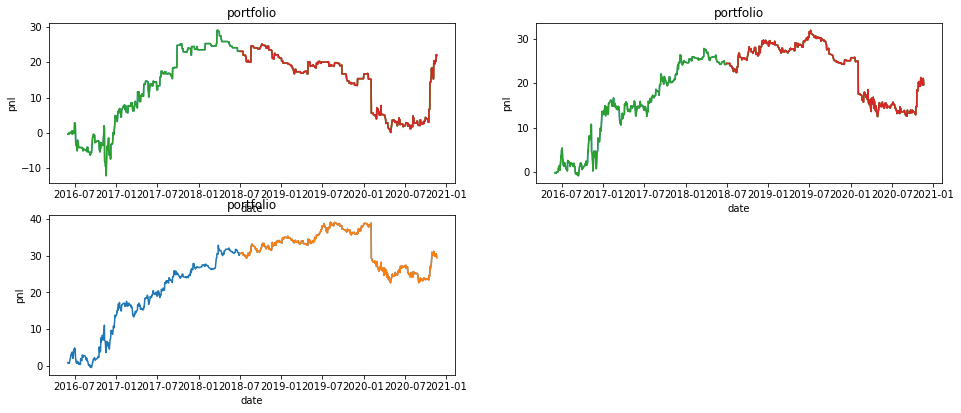

In [132]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "201807", min_pnl=2, min_num=20,reverse=1)


signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, split_str="201807", reverse=1, min_pnl=2, min_num=20)
